In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import cv2
import time
from datetime import datetime

# Root directory of the project
ROOT_DIR = os.getcwd()
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
# sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
# from samples.coco import coco

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [2]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_WEIGHTS = os.path.join(MODEL_DIR, "shapes20240121T1823/mask_rcnn_shapes_0030.h5")

In [3]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 5 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    # IMAGE_RESIZE_MODE = "none"
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 768

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8 * 6, 16 * 6, 32 * 6, 64 * 6, 128 * 6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50

In [4]:
class InferenceConfig(ShapesConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


config = InferenceConfig()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(MODEL_WEIGHTS, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead
Re-starting from epoch 30


In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'breech-face impression', 'aperture shear',
               'firing pin impression', 'firing pin drag']

# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = cv2.imread('1.png')
if image.ndim == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
# test a single image


# check current time
current = datetime.now()
# Run detection
results = model.detect([image], verbose=1)
end = datetime.now()
print("Detected time:", end - current)

Processing 1 images
image                    shape: (376, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 768, 768, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  768.00000  float64
anchors                  shape: (1, 147312, 4)        min:   -0.70803  max:    1.62459  float32


C:\anaconda3\envs\cartridge\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Detected time: 0:00:03.319836


In [6]:
def show(img):
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show

In [7]:
%matplotlib inline

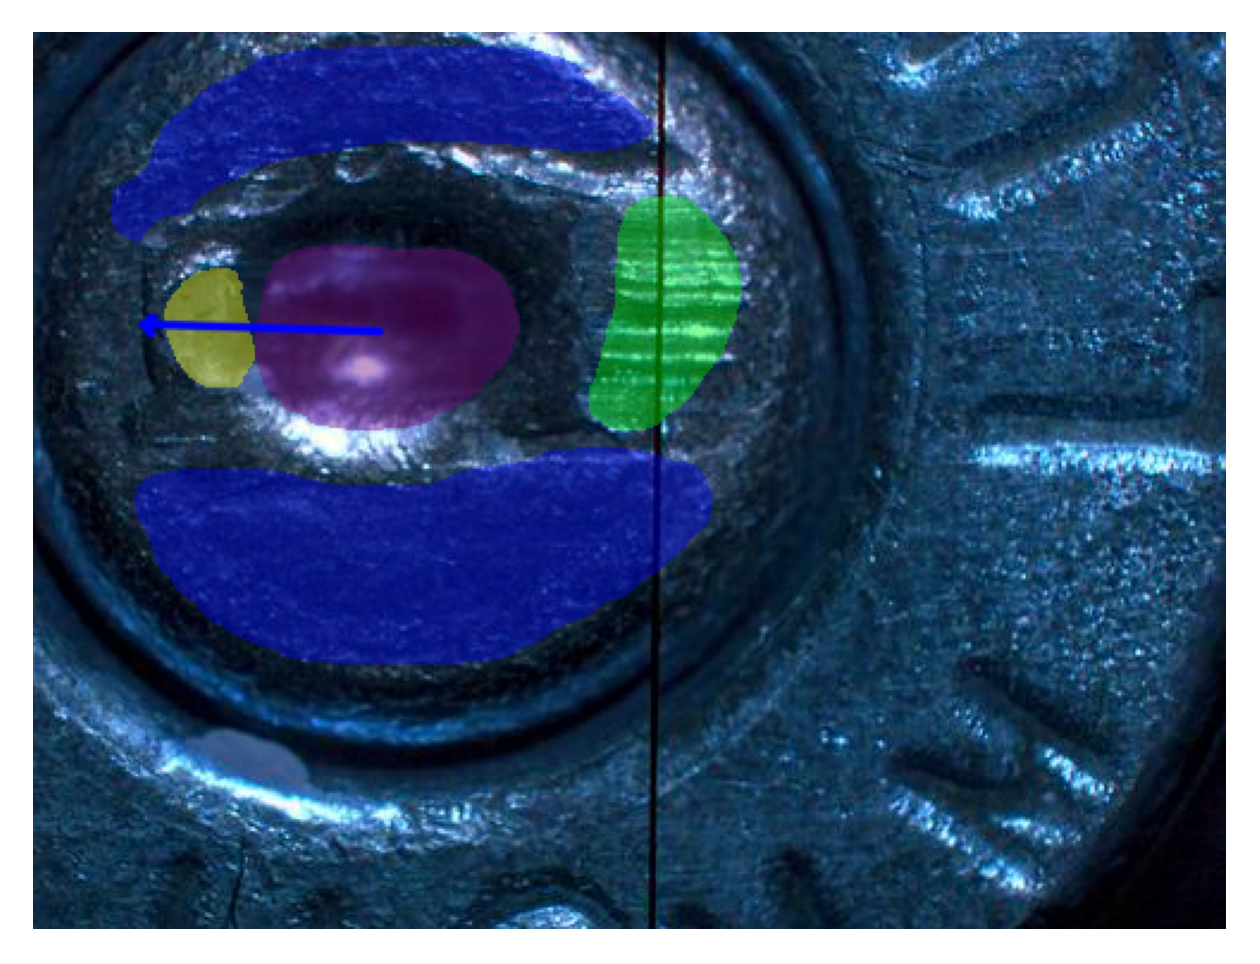

In [8]:
# Visualize results
bgr_colors = [(0.0, 0.0, 1.0),  # breech-face impression (red)
              (0.0, 1.0, 0.0),  # aperture shear (green)
              (128 / 255.0, 0.0, 128 / 255.0),  # firing pin impression (purple)    
              (1.0, 1.0, 0.0)]  # firing pin drag (light blue)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            class_names, r['scores'], show_bbox=False, colors=bgr_colors, captions=None)

In [12]:
rgb_colors = [(1.0, 0.0, 0.0),  # breech-face impression (red)
                          (0.0, 1.0, 0.0),  # aperture shear (green)
                          (128 / 255.0, 0.0, 128 / 255.0),  # firing pin impression (purple)    
                          (0.0, 1.0, 1.0)]  # firing pin drag (light blue)

In [23]:
import os
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox

In [24]:
def select_images():
    file_paths = filedialog.askopenfilenames(filetypes=[("Image Files", "*.jpg;*.png")])
    if file_paths:
        listbox.delete(0, tk.END)
        for file_path in file_paths:
            listbox.insert(tk.END, file_path)

In [25]:
def generate_images():
    file_paths = listbox.get(0, tk.END)
    if not file_paths:
        messagebox.showerror("Error", "No files selected!")
        return

    for file_path in file_paths:
        try:
            # Load the selected image
            image = cv2.imread(file_path)
            if image.ndim == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            # check current time
            current = datetime.now()
            # Run detection
            results = model.detect([image], verbose=1)
            end = datetime.now()
            print("Detected time:", end - current)
            
            # Generate a related image filename
            name, ext = os.path.splitext(os.path.basename(file_path))
            new_file_path = ROOT_DIR + "/" + name + "_masked" + ext
            # Visualize results
            r = results[0]
            visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                                        class_names, r['scores'], show_bbox=False, 
                                        colors=rgb_colors, file_path=new_file_path, captions=None)
            print(new_file_path)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to generate the related image for {file_path}.\n{str(e)}")
            continue

    messagebox.showinfo("Success", "Related images generated.")

In [26]:
# Create the main window
root = tk.Tk()
root.title("Image Masker")

# Create a label for the file list
label = tk.Label(root, text="Selected Images:")
label.pack(side=tk.TOP, fill=tk.X, padx=10, pady=(10, 0))

# Create a listbox widget for the file paths
listbox = tk.Listbox(root, width=50, selectmode=tk.EXTENDED)
listbox.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=10, pady=(0, 5))

# Create a "Select" button for choosing images
select_button = tk.Button(root, text="Select Images", command=select_images)
select_button.pack(side=tk.TOP, fill=tk.X, padx=10, pady=(5, 0))

# Create a "Generate" button to create related images
generate_button = tk.Button(root, text="Masking Images", command=generate_images)
generate_button.pack(side=tk.TOP, fill=tk.X, padx=10, pady=(5, 10))

# Run the main loop
root.mainloop()